### Canal Phase FLIP NÃO MARKOVIANO

In [1]:
from sympy import *
import numpy as np

init_printing(use_unicode=True)
from matplotlib import pyplot as plt
%matplotlib inline
from sympy.physics.quantum.dagger import Dagger
from sympy.physics.quantum import TensorProduct
import scipy.interpolate
import platform

In [2]:
def cb(d, j):
    cbs = zeros(d,1); cbs[j] = 1
    return cbs
def proj(psi):
    return psi*Dagger(psi)

def coh_l1(rho):
    d = rho.shape[0]; C = 0
    for j in range(0,d-1):
        for k in range(j+1,d):
            C += abs(rho[j,k])
    return 2*C

def Pauli(j):
    if j == 0:
        return Matrix([[1,0],[0,1]])
    elif j == 1:
        return Matrix([[0,1],[1,0]])
    elif j == 2:
        return Matrix([[0,-1j],[1j,0]])
    elif j == 3:
        return Matrix([[1,0],[0,-1]])

In [69]:
#from noMarkov.tools import EoF
'''   ENTROPY.PY                 '''
import math
import scipy.linalg.lapack as lapak
import sys
sys.path.append('..')
import src.pTrace

def purity(rho):
    d = rho.shape[0]
    purity = 0.0
    j = -1
    while (j < d-1):
        j = j + 1
        k = -1
        while (k < d-1):
            k = k + 1
            purity += (rho[j][k].real)**2 + (rho[j][k].imag)**2
    return purity

def linear_entropy(rho):
    return 1-purity(rho)

def shannon(pv):
    d = pv.shape[0]
    SE = 0.0
    j = -1
    while (j < d-1):
        j = j + 1
        if pv[j] > 1.e-15 and pv[j] < (1.0-1.e-15):
            SE -= pv[j]*math.log(pv[j], 2)
    return SE

def von_neumann(rho):
    d = rho.shape[0]
    b = lapak.zheevd(rho)
    VnE = shannon(b[0])
    return VnE

def mutual_info(rho, dl, dr):
    rhor = pTrace.pTraceL(dl, dr, rho)
    rhol = pTrace.pTraceR(dl, dr, rho)
    return von_neumann(rhol) + von_neumann(rhor) - von_neumann(rho)

'''  ENTANGLEMENT.PY   '''
import numpy as np
from numpy import linalg as LA
from math import sqrt


# def concurrence(rho):
    # print(type(rho))
    # ev = np.zeros(4, dtype='float')
    # R = np.zeros((4, 4), dtype=complex)
    # R = np.dot(rho, np.kron(Pauli(2), Pauli(2)))
    # R = np.dot(R, np.conj(rho))
    # R = np.dot(R, np.kron(Pauli(2), Pauli(2)))
    # print(R)
    # print(type(R))
    # ev = LA.eigvals(R)
    # ev = LA.eigvalsh(R)
    # print(ev)
    # evm = max(abs(ev[0]), abs(ev[1]), abs(ev[2]), abs(ev[3]))
    # C = 2.0*sqrt(abs(evm)) - sqrt(abs(ev[0]))
    # C = C - sqrt(abs(ev[1])) - sqrt(abs(ev[2])) - sqrt(abs(ev[3]))
    # if C < 0.0:
        # C = 0.0
    # return C


def EoF(rho):
    pv = np.zeros(2)
    Ec = concurrence(rho)
    pv[0] = (1.0 + np.sqrt(1.0 - Ec**2.0))/2.0
    pv[1] = 1.0 - pv[0]
    EF = shannon(2, pv)
    return EF


def negativity(d, rhoTp):
    from distances import normTr
    En = 0.5*(normTr(d, rhoTp) - 1.0)
    return En


def log_negativity(d, rhoTp):
    En = negativity(d, rhoTp)
    Eln = np.log(2.0*En+1.0, 2)
    return Eln


def chsh(rho):  # arXiv:1510.08030
    import gell_mann as gm
#    cm = np.zeros(3, 3)
    cm = gm.corr_mat(2, 2, rho)
    W = np.zeros(3)
    # W = LA.eigvalsh(cm)
    u, W, vh = LA.svd(cm, full_matrices=True)
    no = np.sqrt(2)-1
    nl = (sqrt(W[0]**2+W[1]**2+W[2]**2-min(W[0], W[1], W[2])**2)-1)/no
    return max(0, nl)


def steering(rho):  # arXiv:1510.08030
    import gell_mann as gm
#    cm = np.zeros(3,3)
    cm = gm.corr_mat(2, 2, rho)
    W = np.zeros(3)
    # W = LA.eigvalsh(cm)
    u, W, vh = LA.svd(cm, full_matrices=True)
    return max(0, (sqrt((W[0]**2)+(W[1]**2)+(W[2]**2))-1)/(sqrt(3)-1))


In [65]:
def TP(a,b):
    return TensorProduct(a,b)

def eVals(A):
    d = A.shape[0]; evals = zeros(d,1)
    eig = A.eigenvects()
    ne = 0
    j = 0
    lk = 0
    while ne < d:
        mult = eig[j][1]
        ne += mult
        nk = lk + mult
        for k in range(lk,nk):
            evals[k] = eig[j][0]
        lk = nk
        j += 1
    return evals

def concurrence(rho):
    R = rho*TP(Pauli(2),Pauli(2))*conjugate(rho)*TP(Pauli(2),Pauli(2))
    evals = zeros(4,1)
    ev = eVals(R)
    evm = max(abs(ev[0]), abs(ev[1]), abs(ev[2]), abs(ev[3]))
    C = 2.0*sqrt(abs(evm)) - sqrt(abs(ev[0])) - sqrt(abs(ev[1])) - sqrt(abs(ev[2])) - sqrt(abs(ev[3]))
    if C < 0.0:
        C = 0.0
    return C

In [5]:
import sys as s

def werner_state(c1, c2, c3):
    # c = [-0.8,-0.8,-0.8]
    c = [c1, c2, c3]
    index = 0
    rho = np.zeros((4,4),dtype=complex)
    for i in range(len(rho)):
        rho[i,i] = 1
    for i in c:
        index += 1
        rho += TensorProduct(i*Pauli(index),Pauli(index))
    print(np.array(rho,dtype=complex))
werner = werner_state(-0.8, -0.8, -0.8)

Mais=(cb(2,0)+cb(2,1))/sqrt(2)
Menos=(cb(2,0)-cb(2,1))/sqrt(2)

[[ 0.2+0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  1.8+0.j -1.6+0.j  0. +0.j]
 [ 0. +0.j -1.6+0.j  1.8+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0.2+0.j]]


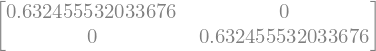

In [39]:
def K_0(J):
    return sqrt(1-J/2)*Pauli(0)

def K_1(J):
    return sqrt(J/2)*Pauli(3)

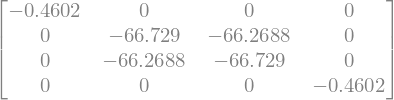

In [41]:
def TP(a,b):
    return TensorProduct(a,b)
def RHO_t_NM(state,J):
    tp1 = TP(K_0(J),K_1(J))
    tp2 = TP(K_1(J),K_0(J))
    return tp1*proj(state)*tp1.T + tp2*proj(state)*tp2.T



In [124]:
def get_list_p_noMarkov(list_p, type):
    lamb = 0.01
    gamma_0 = 1
    list_p_noMarkov = []
    if type == 'Bellomo':
        def non_markov_list_p(lamb,gamma_0,t):
            d = sqrt(2*gamma_0*lamb-lamb**2)
            result = exp(-lamb*t)*(cos(d*t/2)+(lamb/d)*sin(d*t/2))**2
            return result
    if type == 'Ana':
        def non_markov_list_p(lamb,gamma_0,t):
            result = 1-exp(-lamb*t)*(cos(t/2)+(lamb)*sin(t/2))
            return result
    for p in list_p:
        list_p_noMarkov.append(non_markov_list_p(lamb,gamma_0,p))
    return list_p_noMarkov

list_p = np.linspace(0.1,100,10)
t = get_list_p_noMarkov(list_p, 'Ana')
t = get_list_p_noMarkov(list_p, 'Bellomo')
t

[0.0334583488845064, 0.697456192157092, 1.61539002301557, 1.92651991989150, 1.36667707436329, 0.489321812265916, 0.120120841911137, 0.580982564293785, 1.41179893513838, 1.82794291422243, 1.46028436472821, 0.680720450125903, 0.228053014472035, 0.508751218781666, 1.23350988633401, 1.71303453195603, 1.51271782334149, 0.845246583897694, 0.347747128571744, 0.474479072294497, 1.08315853726274, 1.59055180227704, 1.53049723635823, 0.981230021296510, 0.471216702013761, 0.471515669132787, 0.961540150543344, 1.46770242051359, 1.52030827756035, 1.08865969046760, 0.592030698635323, 0.493225046030827, 0.867971425562906, 1.35015204397111, 1.48866261445155, 1.16882534789718, 0.705269593422658, 0.533284357201675, 0.800641319305050, 1.24210013154770, 1.44163943125472, 1.22397761636007, 0.807422205435008, 0.585903681293632, 0.756937282061978, 1.14640605541587, 1.38470251567965, 1.25701784810983, 0.896240799230319, 0.645974059834476]
[0.998752599919147, 0.968583600484849, 0.901001798619498, 0.802133904416

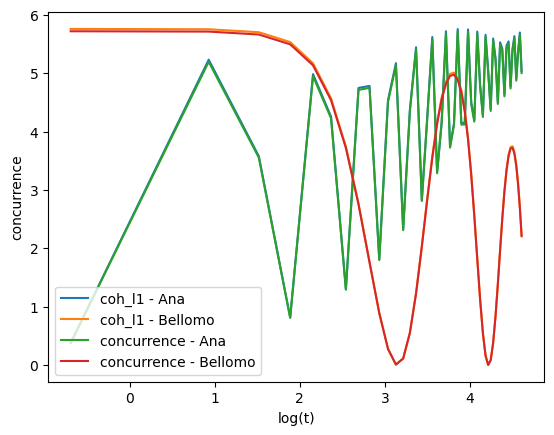

In [131]:
T = np.linspace(0.5,100,50)
t_A = get_list_p_noMarkov(T, 'Ana')
t_B = get_list_p_noMarkov(T, 'Bellomo')
print(t_A)
print(t_B)

state = werner_state(-0.8,-0.8,-0.8)

y1 = [coh_l1(RHO_t_NM(state, i)) for i in t_A]
y2 = [coh_l1(RHO_t_NM(state, i)) for i in t_B]

y3 = [concurrence(RHO_t_NM(state, i)) for i in t_A]
y4 = [concurrence(RHO_t_NM(state, i)) for i in t_B]

T = [ np.log(i) for i in T]

plt.plot(T,y1,label='coh_l1 - Ana')
plt.plot(T,y2,label='coh_l1 - Bellomo')
plt.plot(T,y3,label='concurrence - Ana')
plt.plot(T,y4,label='concurrence - Bellomo')
# plt.plot(T,y2)
plt.ylabel('concurrence')
plt.xlabel('log(t)')
plt.legend()
plt.show()